In [1]:
import os

# Specify the below path to "Data_augmentation_Mosaic_Albumentations_Yolo" folder
path = 'your_path_to/Data_augmentation_Mosaic_Albumentations_Yolo'
os.chdir(path)

In [2]:
! pip3 install -r ./requirements.txt

# Library

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image

import albumentations as A
from sklearn.utils import shuffle
import random, math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

DIR_DATA = './dataset/images'

SEED = 42
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

# Load train_csv data

In [4]:
df = pd.read_csv('./dataset/data_csv.csv', index_col=False)
df.tail()

,image_id,width,height,label,x,y,w,h
39,118,960,960,1,0.555078,0.825694,0.069531,0.129167
40,140,960,960,1,0.425391,0.368750,0.058594,0.087500
41,140,960,960,1,0.569141,0.388194,0.035156,0.084722
42,140,960,960,1,0.971094,0.535417,0.017188,0.084722
43,140,960,960,1,0.375781,0.253472,0.043750,0.070833


## Mosaic

In [5]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4
    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)
    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)
    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)
    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    # Transform label coordinates (Important!!!)
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)
        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T
        # Explanation of this part of code: https://github.com/ultralytics/yolov5/issues/448
        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

In [6]:
def load_image(self, index):
  # loads 1 image from dataset, returns img, original hw, resized hw
  """Load 1 image from dataset
  Input:
    index: idx to search for image's id
  Output:
    img, hw_original, hw_resized """
  # Read an image using opencv2
  image_id = self.image_ids[index]
  imgpath = f'{self.image_dir}/{image_id}.jpg'
  img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

  assert img is not None, 'Image Not Found ' + imgpath
  h0, w0 = img.shape[:2]  # orig hw
  return img, (h0, w0)  # img, hw_original


def load_mosaic(self, index):
    """Load image in a mosaic form _ combines 4 training images into one in certain ratios (instead of only two in CutMix"""
    labels4 = []
    s = self.img_size  # Size of image
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, (h, w) = load_image(self, index)
        # place img in img4
        if i == 0:  # top left
            img4 = np.full(shape=(s * 2, s * 2, img.shape[2]), fill_value=114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b
        # Labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine
    # Reason should add "random_affine()" in mosaic https://github.com/ultralytics/yolov5/issues/448
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=1.98 * 2,
                                  translate=0.05 * 2,
                                  scale=0.05 * 2,
                                  shear=0.641 * 2,
                                  border=-s // 2)  # border to remove
    return img4, labels4

In [7]:
class FPTDatasetMosaic(Dataset):
  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()

    self.df = dataframe  # Annotation & Image's ID dataframe
    self.transforms = transforms  # Albumentation's augmentation
    self.image_ids = shuffle(dataframe['image_id'].unique())  # Image's ID
    self.labels = [np.zeros((0, 4), dtype=np.float32)] * len(self.image_ids) # Image's bboxes
    self.class_labels = [np.zeros((0, 1), dtype=np.float32)] * len(self.image_ids)  # Image's label
    self.img_size = 960
    self.image_dir = image_dir
    self.mosaic = True
    im_w = 1280
    im_h = 720

    # Loop through each image (Each image might containt multiple bboxes & labels)
    for i, img_id in enumerate(self.image_ids):
      records = self.df[self.df['image_id'] == img_id]
      labels = records[['label', 'x', 'y', 'w', 'h']].values  # Annotations
      self.labels[i] = np.array(labels)

      
  def __getitem__(self, index: int):
    if self.mosaic == True:
      # Load mosaic
      img, labels = load_mosaic(self, index)
      shapes = None
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB      
      return img, labels

  def __len__(self) -> int:
    return self.image_ids.shape[0]


In [8]:
def arr_to_str(arr):
  """Transform arr to string & save them to folder dataset_aug"""
  result = str()
  # Arr to String
  label_1 = int(arr[0])
  result = str(label_1) + ' '
  line = ' '.join([str(item) for item in arr[1:]]) + '\n'
  result = result + line
  return result

def pascal_to_yolo(xmin, ymin, xmax, ymax, image_width=640, image_height=640):
  x_coord = (xmin + xmax) / 2 / image_width
  y_coord = (ymin + ymax) / 2 / image_height
  shape_width = (xmax - xmin) / image_width
  shape_height = (ymax - ymin) / image_height
  return x_coord, y_coord, shape_width, shape_height

def yolo_to_pascal(x, y, w, h, width, height):
  xmax = int((x*width) + (w * width)/2.0)
  xmin = int((x*width) - (w * width)/2.0)
  ymax = int((y*height) + (h * height)/2.0)
  ymin = int((y*height) - (h * height)/2.0)
  return xmin, ymin, xmax, ymax

def collate_fn(batch):
    return tuple(zip(*batch))

## Visualize Mosaic images

In [9]:
def construct_mosaic(num_img, df_csv, image_dir):
  """
    Create & filter only mosaic image with # of labels in each image larger than 1
    Input:
      num_img: (int) # of mosaic images wanted to create
      df_csv: (df) .csv metadata file of dataset
      DIR_TRAIN: (str) path direct to images's folder
    Output:
      image_lst: list of mosaic images
      target_lst: list of appropriate mosaic labels
  """
  image_lst = list()
  target_lst = list()
  train_dataset = FPTDatasetMosaic(df_csv, image_dir)  # 792 images
  train_data_loader = DataLoader(
      train_dataset,
      batch_size=16,
      shuffle=True,
      num_workers=4,
      collate_fn=collate_fn
  )
  
  a = 0
  while (a < num_img):
    images, targets = next(iter(train_data_loader))
    for image, target in zip(images, targets):
      if len(target) > 1:
        image_lst.append(image)
        target_lst.append(target)
        a += 1
      else:
        continue
      if a == num_img:
        break
  return image_lst, target_lst

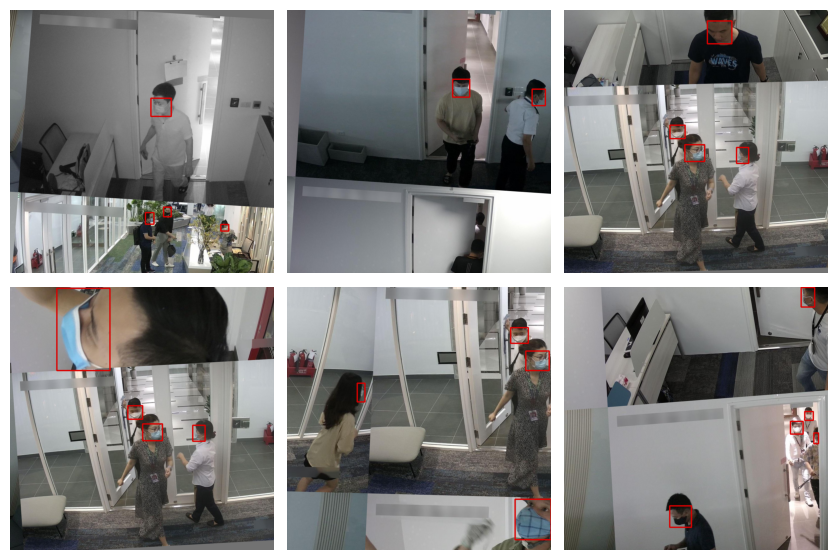

In [32]:
# Construct mosaic images
images, targets = construct_mosaic(num_img=6, df_csv=df, image_dir=DIR_DATA)

# Visualize
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()

for i in range(6):  # Go through each batch 
    boxes = targets[i]
    sample = images[i]
    height, width = sample.shape[:2]
    for box in boxes:
        cv2.rectangle(sample,
                      (int(box[1]), int(box[2])),
                      (int(box[3]), int(box[4])),
                      220, 3)
    ax[i].imshow(sample)  # Visualize a sample for each batch
    ax[i].axis('off')

plt.subplots_adjust(left=0, right=0.9, bottom=0, top=0.9, wspace=-0.2, hspace=0.05)
# plt.savefig('./others/mosaic.png', dpi=300, bbox_inches='tight')
plt.show()

## Save mosaic images to folder

In [36]:
def save_mosaic(images, targets, save_labels_path, save_images_path):
  """Save the mosaic images & labels into image's folder & label's folder
  Input:
    images: (list) of mosaic images (np) 
    targets: (list) of associated mosaic labels (np)
    save_labels_path: (str) path folder used to save .txt labels
    save_images_path: (str) path folder used to save .jpg images
  """
  a1 = 0
  b1 = 0

  for img, label in zip(images, targets):
    height, width = img.shape[:2]
    a1 += 1
    txt_file = open(f'{save_labels_path}/img_mosaic_{a1}.txt', 'w')
    
    # Through each bbox of an image
    for j in range(len(label)):
      # Normalize the box's annotation after augmentation (AS requirement from competition)
      a,b,c,d = pascal_to_yolo(label[j][1], label[j][2], label[j][3], label[j][4], width, height)
      label_yolo = np.array([label[j][0], a, b, c, d])
      label_yolo = arr_to_str(label_yolo)
      txt_file.write(label_yolo)
    txt_file.close()
    print(f'FINISH SAVING MOSAIC LABELS: {save_labels_path}/img_mosaic_{a1}.txt')

  # Save images into folder "images/train"
  for img in images:
    b1 += 1
    im = Image.fromarray(img, "RGB")
    im.save(f'{save_images_path}/img_mosaic_{b1}.jpg')
    print(f'FINISH SAVING MOSAIC IMAGES TO FOLDER: {save_images_path}/img_mosaic_{b1}.jpg')

In [37]:
# Save the created mosaic images to folder
save_mosaic(images, targets, "./dataset/mosaic/labels", "./dataset/mosaic/images")

FINISH SAVING MOSAIC LABELS: ./dataset/mosaic/labels/img_mosaic_1.txt
FINISH SAVING MOSAIC LABELS: ./dataset/mosaic/labels/img_mosaic_2.txt
FINISH SAVING MOSAIC LABELS: ./dataset/mosaic/labels/img_mosaic_3.txt
FINISH SAVING MOSAIC LABELS: ./dataset/mosaic/labels/img_mosaic_4.txt
FINISH SAVING MOSAIC LABELS: ./dataset/mosaic/labels/img_mosaic_5.txt
FINISH SAVING MOSAIC LABELS: ./dataset/mosaic/labels/img_mosaic_6.txt
FINISH SAVING MOSAIC IMAGES TO FOLDER: ./dataset/mosaic/images/img_mosaic_1.jpg
FINISH SAVING MOSAIC IMAGES TO FOLDER: ./dataset/mosaic/images/img_mosaic_2.jpg
FINISH SAVING MOSAIC IMAGES TO FOLDER: ./dataset/mosaic/images/img_mosaic_3.jpg
FINISH SAVING MOSAIC IMAGES TO FOLDER: ./dataset/mosaic/images/img_mosaic_4.jpg
FINISH SAVING MOSAIC IMAGES TO FOLDER: ./dataset/mosaic/images/img_mosaic_5.jpg
FINISH SAVING MOSAIC IMAGES TO FOLDER: ./dataset/mosaic/images/img_mosaic_6.jpg
